In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Load CSV into DataFrames
measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")
stations_df = pd.read_csv("Resources/hawaii_stations.csv")

In [6]:
measurements_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [7]:
stations_df

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [8]:
# reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)

# reflect the tables
Base = automap_base(metadata=metadata)
Base.prepare()

measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")
stations_df = pd.read_csv("Resources/hawaii_stations.csv")

HawaiiMeasurements = Base.classes.measurement
HawaiiStations = Base.classes.station

print(metadata.tables.keys())


dict_keys(['hawaii_measurements', 'hawaii_stations', 'measurement', 'station'])


In [9]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
from datetime import datetime, timedelta

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

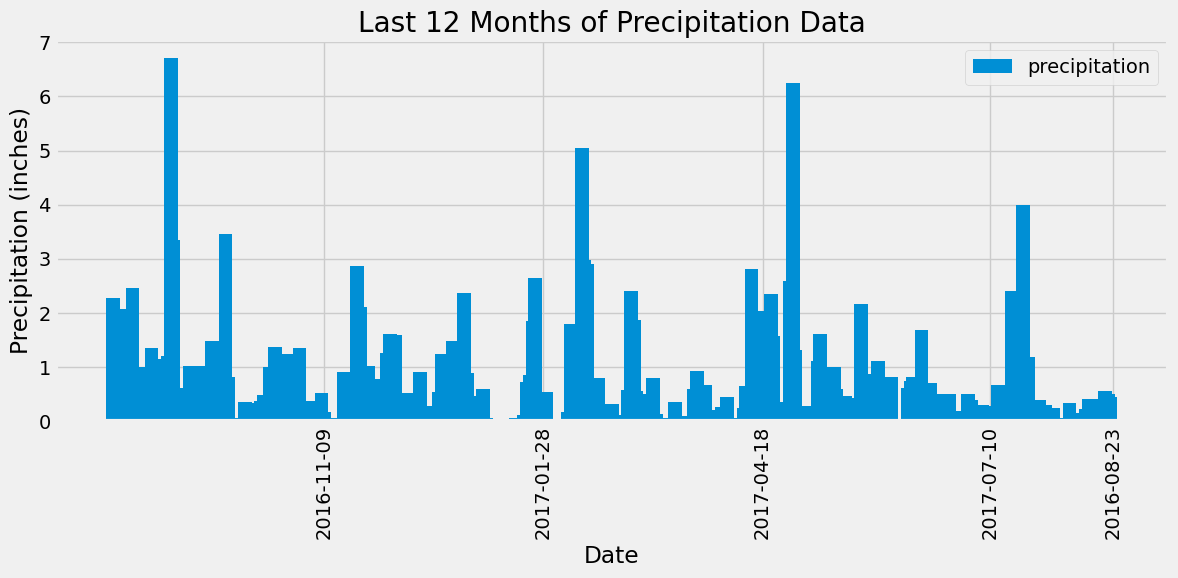

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_yr_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_yr_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values('date')

#Set the style
plt.style.use('fivethirtyeight')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,6))
plt.bar(df['date'], df['precipitation'], width=5, label='precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45)
desired_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(desired_dates, rotation=90)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# THIS IS NOT WORKING##

starter code shows preciptiation at 2021.0000, mean at 0.177279 and std at 0.471190

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()

summary_df = pd.DataFrame(summary_stats)

summary_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

for station, count in most_active:
    print(f"Station {station}: {count} rows")

Station USC00519281: 2772 rows
Station USC00519397: 2724 rows
Station USC00513117: 2709 rows
Station USC00519523: 2669 rows
Station USC00516128: 2612 rows
Station USC00514830: 2202 rows
Station USC00511918: 1979 rows
Station USC00517948: 1372 rows
Station USC00518838: 511 rows


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = most_active[0][0]

temp_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active)\
        .all()

lowest_temp, highest_temp, avg_temp = temp_summary[0]
print(f"Most active station: {most_active}")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp} °F")

Most active station: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


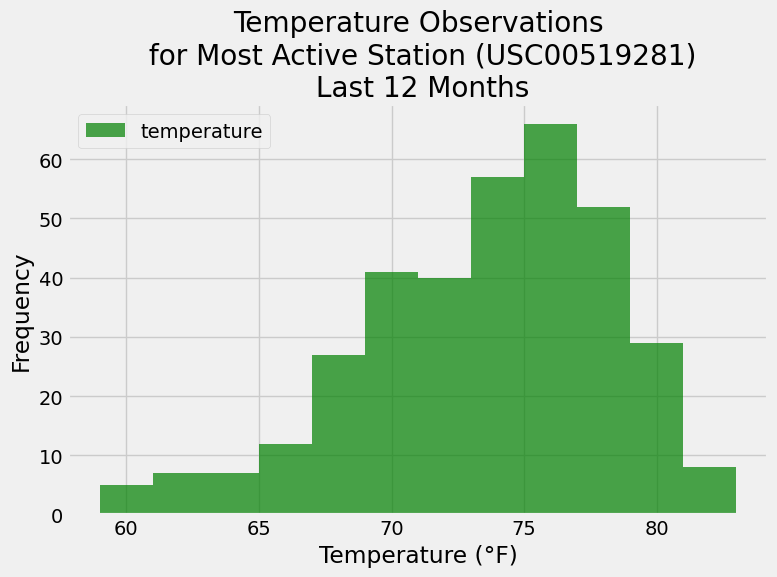

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active = most_active[0][0]

most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
one_yr_ago = most_recent_date - timedelta(days=365)

# Query for the station with the most observations
most_observed_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()[0]

# Query the temperature data for the most observed station in the last 12 months
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_observed_station).\
    filter(Measurement.date >= one_yr_ago).\
    all()

# Extract temperature values from the query results
temperatures = [temp[0] for temp in temp_data]

# Set the plot style
plt.style.use('fivethirtyeight')

# Plot the historgram
plt.figure(figsize=(8,6))
plt.hist(temperatures, bins=12, label='temperature', alpha=0.7, color='green')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations\n for Most Active Station ({most_observed_station})\n Last 12 Months')
plt.legend()
plt.tight_layout()

plt.show()

# Close Session

In [ ]:
# Close Session
session.close()